In [1]:
import itertools
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import ode
from tqdm import tqdm

! gdown --id 1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
from kernel_pde_utils import *
# test_step1()
# test_step2()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
To: /content/kernel_pde_utils.py
100% 4.81k/4.81k [00:00<00:00, 10.4MB/s]


# Kernel Regression with Lorenz System

In [2]:
# Chaotic Lorenz parameters.
sigma, rho, beta = 10, 28, 8/3

def generate_lorenz_data(t):
    """
    Given a time vector t = t1, t2, ..., evaluates and returns the snapshots
    of the Lorenz system as columns of the matrix X via explicit Runge-Kutta.
    """
    def lorenz_system(t, state, par):
        """
        Defines the system of differential
        equations y'(t) = f(t, y, params).
        """
        x, y, z = state
        sigma, rho, beta = par
        x_dot = sigma * (y - x)
        y_dot = (x * (rho - z)) - y
        z_dot = (x * y) - (beta * z)
        return np.array((x_dot, y_dot, z_dot))

    # Initial condition.
    initial = np.array((-8, 8, 27))

    # Generate Lorenz system data.
    X = np.empty((3, len(t)))
    X[:, 0] = initial
    r = ode(lorenz_system).set_integrator("dopri5")
    r.set_initial_value(initial, t[0])
    r.set_f_params((sigma, rho, beta))
    for i, ti in enumerate(t):
        if i == 0:
            continue
        r.integrate(ti)
        X[:, i] = r.y

    return X

def get_true_funcs(xyz):
    """
    Computes and returns the expected xyz time derivatives 
    from xyz data based on the true governing equations.
    """
    # True differential equations.
    x, y, z = xyz
    P1_true = sigma * (y - x)
    P2_true = (x * (rho - z)) - y
    P3_true = (x * y) - (beta * z)
    P_true = np.vstack([P1_true, P2_true, P3_true])
    return P_true

def get_sindy_funcs(model, xyz_data):
    """
    Given a SINDy model and the corresponding xyz data, computes
    and returns the estimated xyz time derivatives based on the
    governing equations found by the model.
    """
    x, y, z = xyz_data
    one = np.ones(len(x))
    features = np.vstack([one, x, y, z, x*x, x*y, x*z, y*y, y*z, z*z]).T
    return features.dot(model.coefficients().T).T

def compute_error(true, est):
    """Relative error."""
    return np.linalg.norm(true - est) / np.linalg.norm(true)

def kernel_pipeline(xyz, t, params):
    """
    Applies the kernel PDE regression pipeline to the given data. Returns
    the computed smoothed data, the P(S) functions evaluated at the given
    data points, and the general P(S) functions.
    """
    # Get smooth data.
    t = t[:, None]
    smooth_xyz = np.empty(xyz.shape)
    for i, u in enumerate(xyz):
        u_func_smooth = kernel_smoothing(
            t, u, kernel_metric="rbf",
            kernel_params={"gamma":params["gamma_smooth"]},
            _lambda=params["lambda_smooth"],
        )
        smooth_xyz[i] = u_func_smooth(t)

    # Get derivatives using smooth data.
    d_xyz = np.empty(xyz.shape)
    for i, u_smooth in enumerate(smooth_xyz):
        du_func = kernel_diff(
            t, u_smooth, d=1, kernel_metric="rbf",
            kernel_params={"gamma":params["gamma_smooth"]},
            _lambda=params["lambda_smooth"],
        )
        d_xyz[i] = np.array([du_func(np.array(tj)) for tj in t.squeeze()])
        # Smooth the derivatives.
        du_func_smooth = kernel_smoothing(
            t, d_xyz[i], kernel_metric="rbf",
            kernel_params={"gamma":params["gamma_smooth"]},
            _lambda=params["lambda_smooth"],
        )
        d_xyz[i] = du_func_smooth(t)

    # Apply kernel regression using smooth data.
    P_funcs = []
    S = smooth_xyz.T
    for du in d_xyz:
        P_funcs.append(
            kernel_regression(
                S, du, kernel_metric="poly",
                kernel_params={"gamma":1, "degree":2, "coef0":1},
                _lambda=params["lambda_regress"],
            )
        )
    P_kernel = np.vstack([P_funcs[0](S), P_funcs[1](S), P_funcs[2](S)])

    return smooth_xyz, P_kernel, P_funcs

def cross_validation(
    xyz, t, num_batch,
    all_gamma_smooth=[1, 5, 10, 20, 50],
    all_lambda_smooth=[1e-5, 1e-4, 1e-3],
    all_lambda_regress=[1e-5, 1e-4, 1e-3],
):
    """
    xyz.shape = (3, J)
    t.shape = (J,)
    """
    # Initialize the loss.
    current_loss = np.inf
    best_params = dict()
    best_params["gamma_smooth"] = 50
    best_params["lambda_smooth"] = 1e-5
    best_params["lambda_regress"] = 1e-5

    # Define the training and validation batches.
    xyz_batches = np.split(xyz, num_batch, axis=1)
    t_batches = np.split(t, num_batch)

    for (a, b, c) in tqdm(itertools.product(all_gamma_smooth, all_lambda_smooth, all_lambda_regress)):
        # Specify kernel pipeline parameters.
        params = dict()
        params["gamma_smooth"] = a
        params["lambda_smooth"] = b
        params["lambda_regress"] = c

        # Record the validation error.
        validation_error = np.empty(num_batch)

        for i, (xyz_val, t_val) in enumerate(zip(xyz_batches, t_batches)):
            xyz_train = np.hstack([batch for j, batch in enumerate(xyz_batches) if j != i])
            t_train = np.setdiff1d(t, t_val)
            P_true_train = get_true_funcs(xyz_train)
            P_kernel = kernel_pipeline(xyz_train, t_train, params)[1]
            validation_error[i] = compute_error(P_true_train, P_kernel)

        if np.average(validation_error) < current_loss:
            current_loss = np.average(validation_error)
            best_params["gamma_smooth"] = a
            best_params["lambda_smooth"] = b
            best_params["lambda_regress"] = c

    return best_params

# Initial Pipeline Application

0it [00:00, ?it/s]WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
45it [06:30,  8.68s/it]


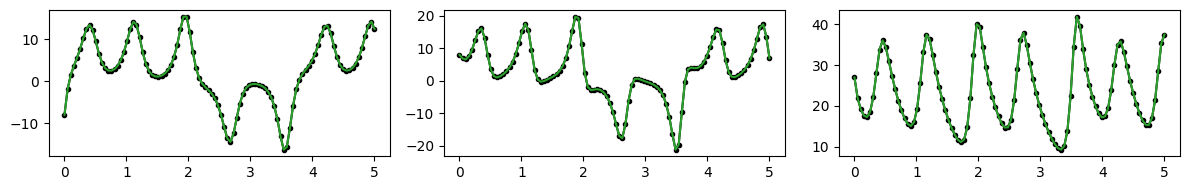

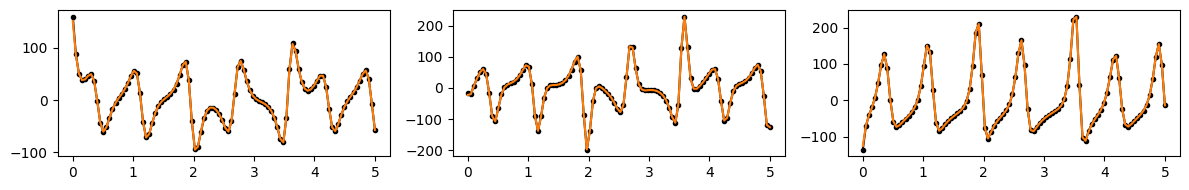

0.014479738685566564


In [3]:
# Generate chaotic Lorenz System data.
t = np.linspace(0, 5, 100)
xyz = generate_lorenz_data(t)
P_true = get_true_funcs(xyz)

# Apply the pipeline!
best_params = cross_validation(xyz, t, num_batch=5)
smooth_xyz, P_kernel, P_funcs = kernel_pipeline(xyz, t, best_params)

# Plot smooth data.
plt.figure(figsize=(12, 2))
for i, u in enumerate(xyz):
    plt.subplot(1, 3, i + 1)
    plt.plot(t, u, ".-", c="k")
    plt.plot(t, smooth_xyz[i], c="tab:green")
plt.tight_layout()
plt.show()
# Plot learned functions.
plt.figure(figsize=(12, 2))
for i, (truth, est) in enumerate(zip(P_true, P_kernel)):
    plt.subplot(1, 3, i + 1)
    plt.plot(t, truth, ".-", c="k")
    plt.plot(t, est, c="tab:orange")
plt.tight_layout()
plt.show()

# Print error.
print(compute_error(P_true, P_kernel))

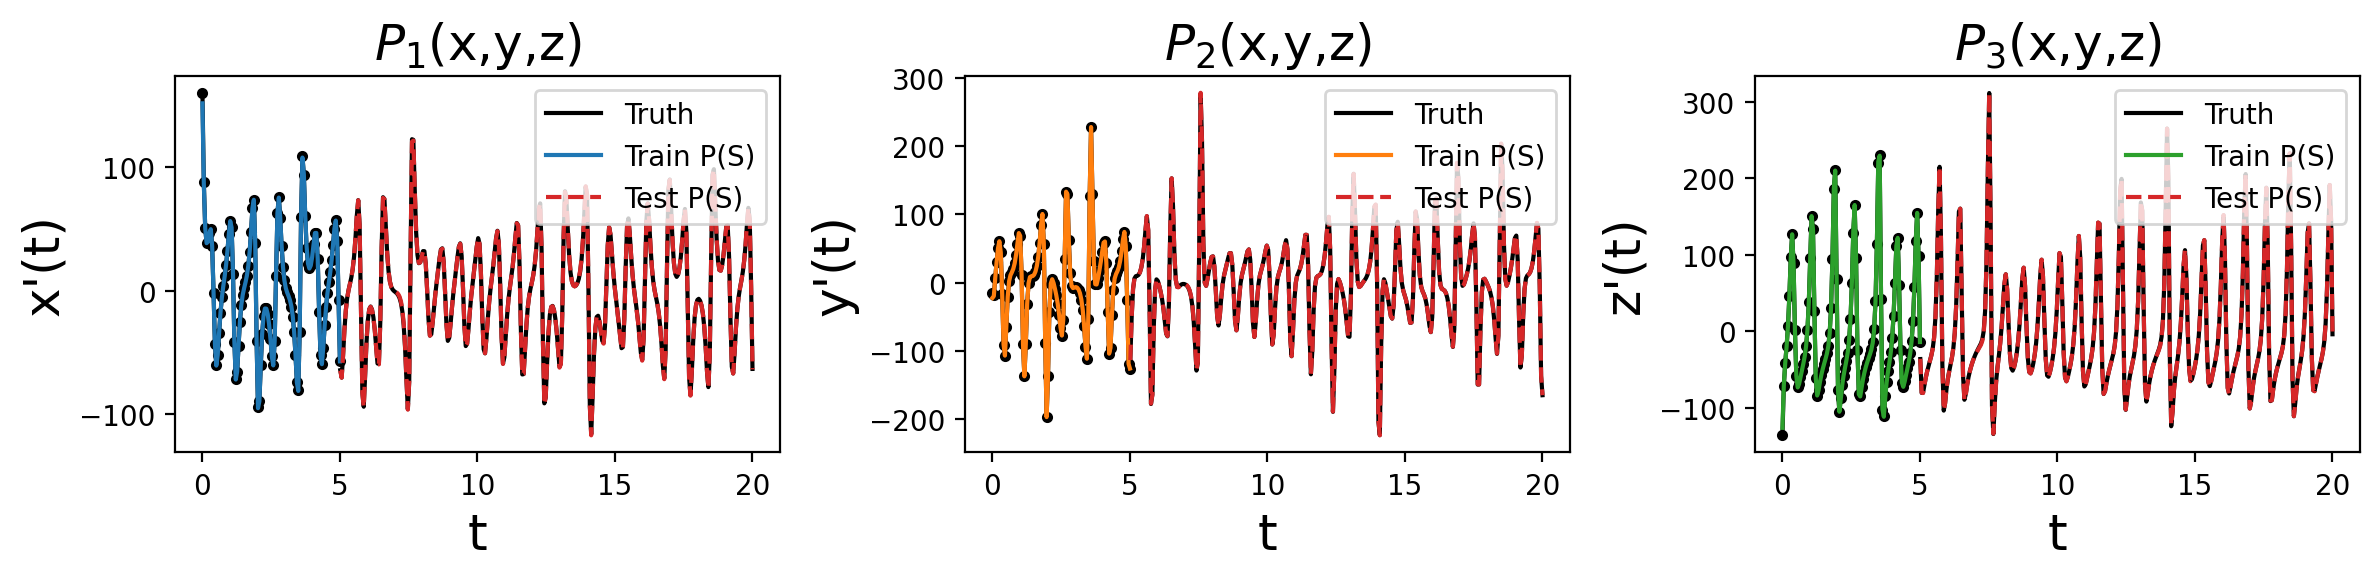

In [4]:
# Get long data set.
# t = np.linspace(0, 5, 100)
t_long = np.linspace(0, 20, 400)
xyz_long = generate_lorenz_data(t_long)
P_true_long = get_true_funcs(xyz_long)
smooth_xyz_long = kernel_pipeline(xyz_long, t_long, best_params)[0]
S_long = smooth_xyz_long.T
P_kernel_long = np.vstack([P_funcs[0](S_long), P_funcs[1](S_long), P_funcs[2](S_long)])

colors = ["tab:blue", "tab:orange", "tab:green"]
titles = ["$P_1$(x,y,z)", "$P_2$(x,y,z)", "$P_3$(x,y,z)"]
labels = ["x'(t)", "y'(t)", "z'(t)"]

# Plot learned functions.
plt.figure(figsize=(12, 3), dpi=200)
for i, (truth, est, truth_long, est_long) in enumerate(
    zip(P_true, P_kernel, P_true_long, P_kernel_long)
):
    plt.subplot(1, 3, i + 1)
    plt.title(titles[i], fontsize=18)
    plt.plot(t, truth, ".-", c="k")
    plt.plot(t_long[len(t):], truth_long[len(t):], c="k", label="Truth")
    plt.plot(t, est, c=colors[i], label="Train P(S)")
    plt.plot(t_long[len(t):], est_long[len(t):], "--", c="tab:red", label="Test P(S)")
    plt.xlabel("t", fontsize=18)
    plt.ylabel(labels[i], fontsize=18)
    plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [5]:
best_params

{'gamma_smooth': 50, 'lambda_smooth': 0.0001, 'lambda_regress': 0.0001}

# Noise experiments

In [ ]:
# Generate chaotic Lorenz System data.
t = np.linspace(0, 5, 100)
xyz_clean = generate_lorenz_data(t)
P_true = get_true_funcs(xyz_clean)

# Noise experiment stuff.
num_trials = 10
noise_vals = np.logspace(-6, 1, 8)
noise_error_kernel = np.empty((len(noise_vals), num_trials))
noise_error_sindy = np.empty((len(noise_vals), num_trials))

for noise_ind, noise_mag in enumerate(noise_vals):
    print(noise_mag)

    if noise_mag <= 1e-3:
        best_params = dict()
        best_params["gamma_smooth"] = 50
        best_params["lambda_smooth"] = 1e-4
        best_params["lambda_regress"] = 1e-4
    else: # cross validate
        xyz = xyz_clean + (noise_mag * np.random.randn(*xyz_clean.shape))
        best_params = cross_validation(xyz, t, num_batch=5)

    for trial_ind in range(num_trials):
        xyz = xyz_clean + (noise_mag * np.random.randn(*xyz_clean.shape))
        smooth_xyz, P_kernel, _ = kernel_pipeline(xyz, t, best_params)
        model = ps.SINDy(
            optimizer=ps.STLSQ(threshold=0.2),
            feature_library=ps.PolynomialLibrary(degree=2),
        )
        model.fit(smooth_xyz.T, t=t)
        P_sindy = get_sindy_funcs(model, smooth_xyz)

        # Compute error.
        noise_error_kernel[noise_ind, trial_ind] = compute_error(P_true, P_kernel)
        noise_error_sindy[noise_ind, trial_ind] = compute_error(P_true, P_sindy)


1e-06
1e-05
0.0001
0.001
0.01


45it [10:11, 13.58s/it]


0.1


45it [10:14, 13.65s/it]


1.0


45it [10:11, 13.59s/it]


10.0


45it [10:09, 13.54s/it]


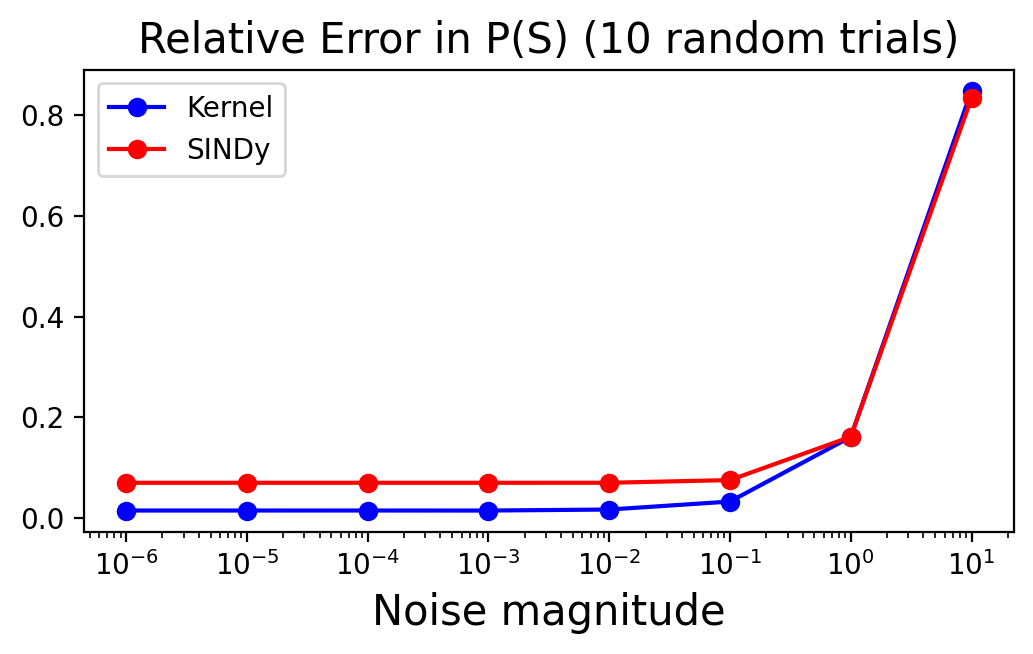

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title(f"Relative Error in P(S) ({num_trials} random trials)", fontsize=15)
plt.plot(noise_vals, np.average(noise_error_kernel, axis=1), "-o", label="Kernel", c="b")
plt.plot(noise_vals, np.average(noise_error_sindy, axis=1), "-o", label="SINDy", c="r")
plt.xlabel("Noise magnitude", fontsize=15)
plt.semilogx()
plt.legend()
plt.show()

# Collocation experiments

In [ ]:
T_vals = np.arange(40, 250, 20)
col_error_kernel = np.empty(len(T_vals))
col_error_sindy = np.empty(len(T_vals))

for T_ind, T in enumerate(T_vals):
    # Generate chaotic Lorenz System data.
    t = np.linspace(0, 5, T)
    xyz = generate_lorenz_data(t)
    P_true = get_true_funcs(xyz)

    # Apply the pipeline!
    best_params = cross_validation(xyz, t, num_batch=5)
    smooth_xyz, P_kernel, _ = kernel_pipeline(xyz, t, best_params)

    ### SINDY METHOD
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=0.2),
        feature_library=ps.PolynomialLibrary(degree=2),
    )
    model.fit(xyz.T, t=t.squeeze())
    P_sindy = get_sindy_funcs(model, xyz)

    ### COMPUTE ERROR
    col_error_kernel[T_ind] = compute_error(P_true, P_kernel)
    col_error_sindy[T_ind] = compute_error(P_true, P_sindy)


45it [03:59,  5.32s/it]
45it [05:58,  7.97s/it]
45it [08:27, 11.27s/it]
45it [10:22, 13.84s/it]
45it [12:39, 16.87s/it]
45it [14:44, 19.66s/it]
45it [16:44, 22.32s/it]
45it [18:45, 25.02s/it]
45it [21:03, 28.08s/it]
45it [23:04, 30.76s/it]
45it [25:28, 33.97s/it]


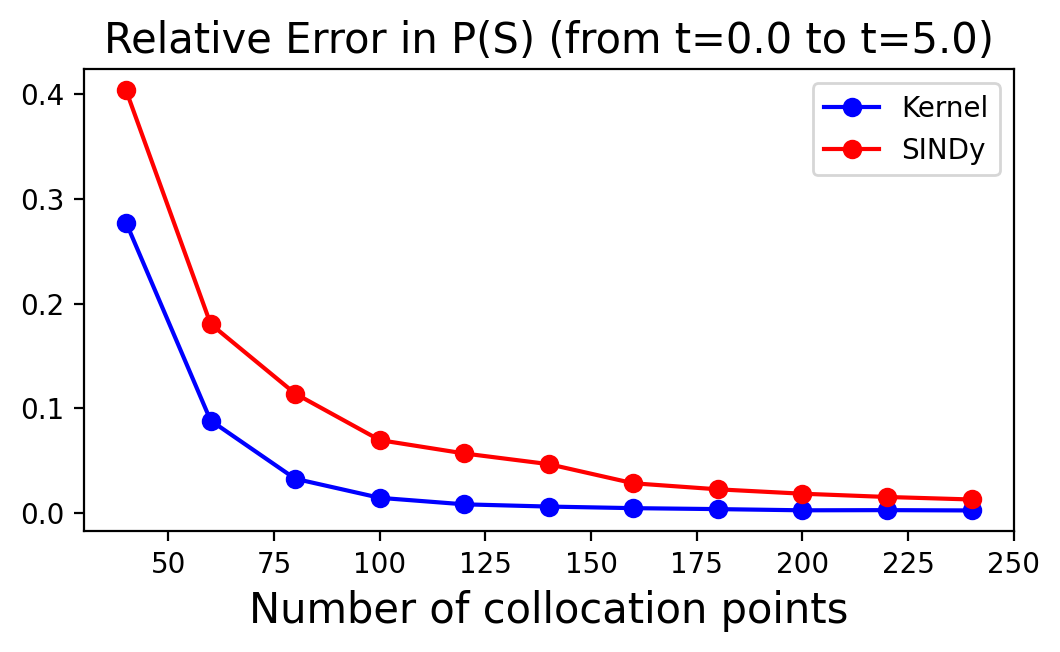

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title(f"Relative Error in P(S) (from t={t[0]} to t={t[-1]})", fontsize=15)
plt.plot(T_vals, col_error_kernel, "-o", label="Kernel", c="b")
plt.plot(T_vals, col_error_sindy, "-o", label="SINDy", c="r")
plt.xlabel("Number of collocation points", fontsize=15)
plt.legend()
plt.show()